# Solver and SLM Accuracy and Runtime Notebook

## Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
# from scipy.interpolate import CubicSpline
from scipy.interpolate import CubicSpline
from matplotlib.ticker import ScalarFormatter
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
# import json


import sys
sys.path.append("./src")
from TOV_class import TOVsolver
from SLM import SLM
import scripts as plot_scripts  # plotting functions
plot_scripts.setup_rc_params()

In [3]:
error_threshold = 1e-6
modes = None  # this will automatically set the number of modes

In [4]:
# # real quick let's get the SLM main code "wrapped" into a function I can call from here

# SLM_modes = 8

# def SLM(X, svdSize=SLM_modes):
#     radius, pres, mass, tidal_def = X
    
#     # get data defined and "formatted"
#     linT = np.arange(len(pres))
#     X = [np.log(radius), np.log(pres), np.log(mass), np.log(tidal_def)]
#     X = np.asarray(X, dtype=np.float64)
    
#     startDMDTime = time.time()
#     phi, omega, lam, b, Xdmd, S = DMD(X, svdSize, (linT[-1] - linT[0]) / len(linT))
#     endDMDTime = time.time()
#     runtime = endDMDTime - startDMDTime
    
#     rad_DMD = np.exp(Xdmd[0].real)
#     pres_DMD = np.exp(Xdmd[1].real)
#     mass_DMD = np.exp(Xdmd[2].real)
#     tidal_DMD = np.exp(Xdmd[3].real)
    
    
#     return rad_DMD, pres_DMD, mass_DMD, tidal_DMD, runtime

In [5]:
eos_path = "../EOS_Data/"

# check the accuracy and runtimes with the tabular EOSs (5 of them)
files_to_check = ["BL_eos.table", 
                  "FSUGarnetNStarEOSA.txt", 
                  "sorted_Sly4.dat", 
                  "DS_CMF_eos.table", 
                  "apr_eos.table"]
eos_names = ["BL", "FSU Garnet", "SLy4", "DSCMF", "APR"]

In [6]:
sol_pts = 4000  # number of points used per iteration for non solve_ivp solvers
number_of_solves = 1  # make this more for checking the runtimes !

# these empty lists will get filled with their corresponding runtimes per solve (size = `number_of_solves * 5`)
HF_runtimes = {"exact": [],
               "RK4": [],
               "RK2": [],
               "euler": []}
SLM_runtimes = {"exact": [],
                "RK4": [],
                "RK2": [],
                "euler": []}

## Calculate Exact (Adaptive) Solver

This uses `solve_ivp`

In [7]:
tol = 3e-14

# store the solutions per EOS
exact_HF_results = {}
exact_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        file_path = f"{eos_path}{file}"
        if not os.path.isfile(file_path):
            print(f"\n\nSkipping {eos_name}: {file_path} not found.")
            continue
        print(f"\n\nChecking {eos_name}: ", end="")
        
        # some solve_ivp methods: "RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"
        # "Radau" is particularly good for stick ODEs (like these). But RK45 should also be good too.
        tov_exact = TOVsolver(file_path, tidal=True, solver="solve_ivp", solve_ivp_kwargs={"method": "RK45", 
                                                                                           "atol": tol, 
                                                                                           "rtol": tol})
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_exact.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["exact"].append(HF_runtime)
        
        # store data
        rad = tov_exact.total_radius
        pres = tov_exact.total_pres_central
        mass = tov_exact.total_mass
        tidal = tov_exact.k2

        X = np.asarray([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)

        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)  # time step for SLM
        print("dt:", dt)
        # X_list = [np.log(r_orig), np.log(p_orig), np.log(m_orig)]
        # if tidal is True:
        #     X_list.append(np.log(tidal_def))
        # X = np.asarray(X_list, dtype=np.float64)

        SLM_start_time = time.time()
        SLM_result = SLM(X, dt, error_threshold=error_threshold, modes=modes)
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["exact"].append(SLM_runtime)

        exact_HF_results[eos_name] = np.exp(X)
        exact_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime:.2}")




Checking BL: Woo it worked!


/Users/joshuamaldonado/Documents/GitHub/SLM/src/TOV_class.py:396: RuntimeWarning: divide by zero encountered in power
  * (
/Users/joshuamaldonado/Documents/GitHub/SLM/src/TOV_class.py:392: RuntimeWarning: invalid value encountered in multiply
  (8.0 / 5.0)
/Users/joshuamaldonado/Documents/GitHub/SLM/src/TOV_class.py:415: RuntimeWarning: divide by zero encountered in divide
  tidal_deform = (2.0 / 3.0) * k2 * (2.0 * self.mass0 * radius / (self.rad0 * mass))**5.0


Max mass:  2.083265 Radius:  10.311491 Central pressure:  782.931436
dt: 0.98
Testing r=1: Max absolute error = 5.875772
Testing r=2: Max absolute error = 1.582500
Testing r=3: Max absolute error = 0.413714
Testing r=4: Max absolute error = 0.155386
Testing r=5: Max absolute error = 0.184217
Testing r=6: Max absolute error = 0.144947
Testing r=7: Max absolute error = 0.107495
Testing r=8: Max absolute error = 1.342384
Testing r=9: Max absolute error = 0.488529
Testing r=10: Max absolute error = 0.055930
Testing r=11: Max absolute error = 0.088528
Testing r=12: Max absolute error = 0.009613
Testing r=13: Max absolute error = 0.001100
Testing r=14: Max absolute error = 0.001130
Optimal 'r' determined: 13 (Max absolute error = 0.001100)
HF solved in 25.78 seconds.
SLM solved in 0.00185 seconds.
speedup: 1.4e+04


Checking FSU Garnet: Woo it worked!
Max mass:  2.066411 Radius:  11.604492 Central pressure:  352.826244
dt: 0.98
Testing r=1: Max absolute error = 5.654696
Testing r=2: Max abso

/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


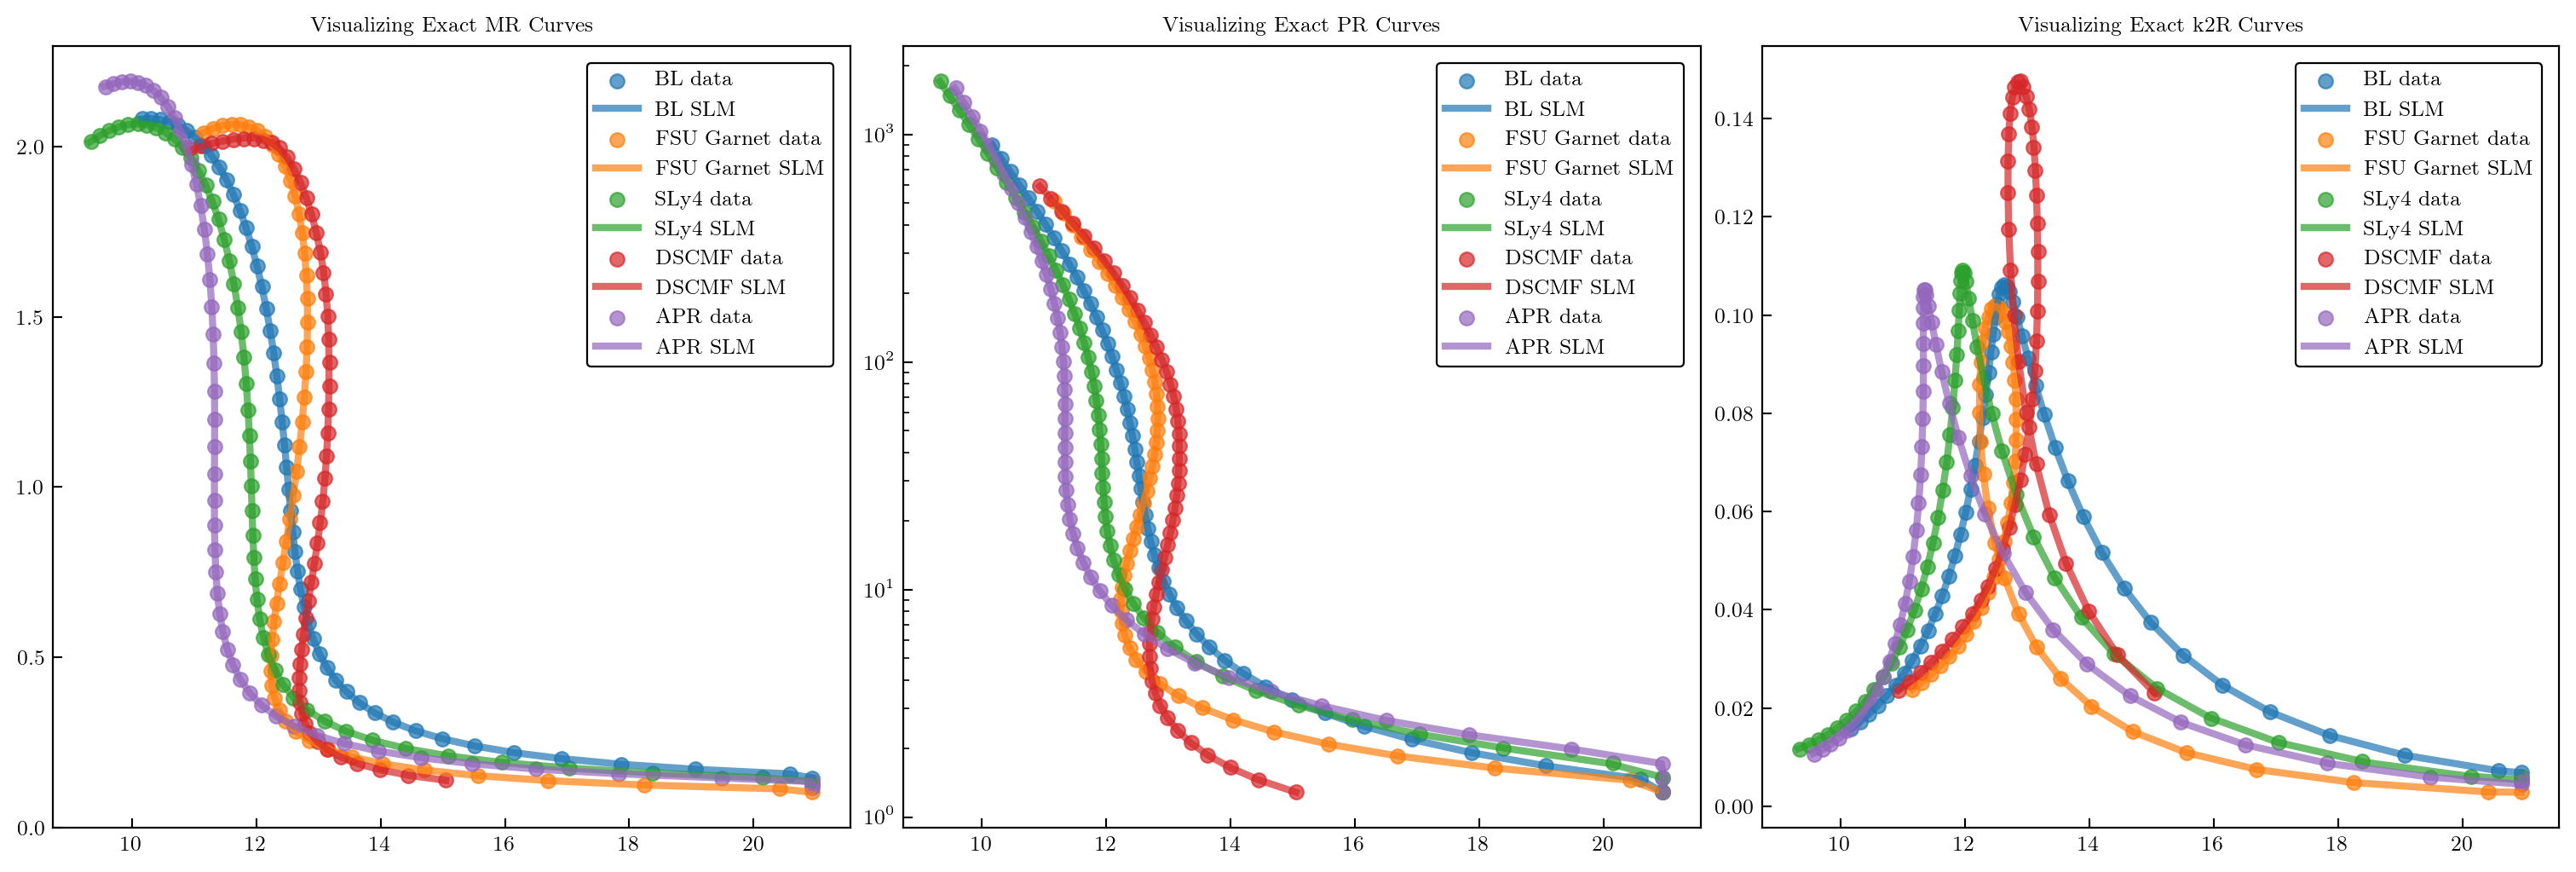

In [8]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing Exact MR Curves")
for eos in eos_names:
    ax[0].scatter(exact_HF_results[eos][0], exact_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing Exact PR Curves")
for eos in eos_names:
    ax[1].scatter(exact_HF_results[eos][0], exact_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].set_yscale("log")
ax[1].legend()

ax[2].set_title("Visualizing Exact k2R Curves")
for eos in eos_names:
    ax[2].scatter(exact_HF_results[eos][0], exact_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Check RK4 solver

In [9]:
# store the solutions per EOS
RK4_HF_results = {}
RK4_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK4 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK4", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK4.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK4"].append(HF_runtime)
        
        # store data
        rad = tov_RK4.total_radius
        pres = tov_RK4.total_pres_central
        mass = tov_RK4.total_mass
        tidal = tov_RK4.k2


        X = np.array([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        # X_SLM = SLM(X, dt, error_threshold=error_threshold)[4]
        SLM_result = SLM(X, dt, error_threshold=error_threshold, modes=modes)
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["RK4"].append(SLM_runtime)

        RK4_HF_results[eos_name] = np.exp(X)
        RK4_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime:.2}")
#




Checking BL: Woo it worked!
Max mass:  2.083265 Radius:  10.310742 Central pressure:  782.931436
Testing r=1: Max absolute error = 6.899944
Testing r=2: Max absolute error = 1.979828
Testing r=3: Max absolute error = 0.643123
Testing r=4: Max absolute error = 0.290740
Testing r=5: Max absolute error = 0.040906
Testing r=6: Max absolute error = 0.028735
Testing r=7: Max absolute error = 0.007598
Testing r=8: Max absolute error = 0.008429
Testing r=9: Max absolute error = 0.006506
Testing r=10: Max absolute error = 0.002991
Testing r=11: Max absolute error = 0.002428
Testing r=12: Max absolute error = 0.003030
Testing r=13: Max absolute error = 0.002997
Testing r=14: Max absolute error = 0.002096
Optimal 'r' determined: 14 (Max absolute error = 0.002096)
HF solved in 18.57 seconds.
SLM solved in 0.001965 seconds.
speedup: 9.4e+03


Checking FSU Garnet: Woo it worked!
Max mass:  2.066411 Radius:  11.600631 Central pressure:  352.826244
Testing r=1: Max absolute error = 5.677789
Testing 

/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


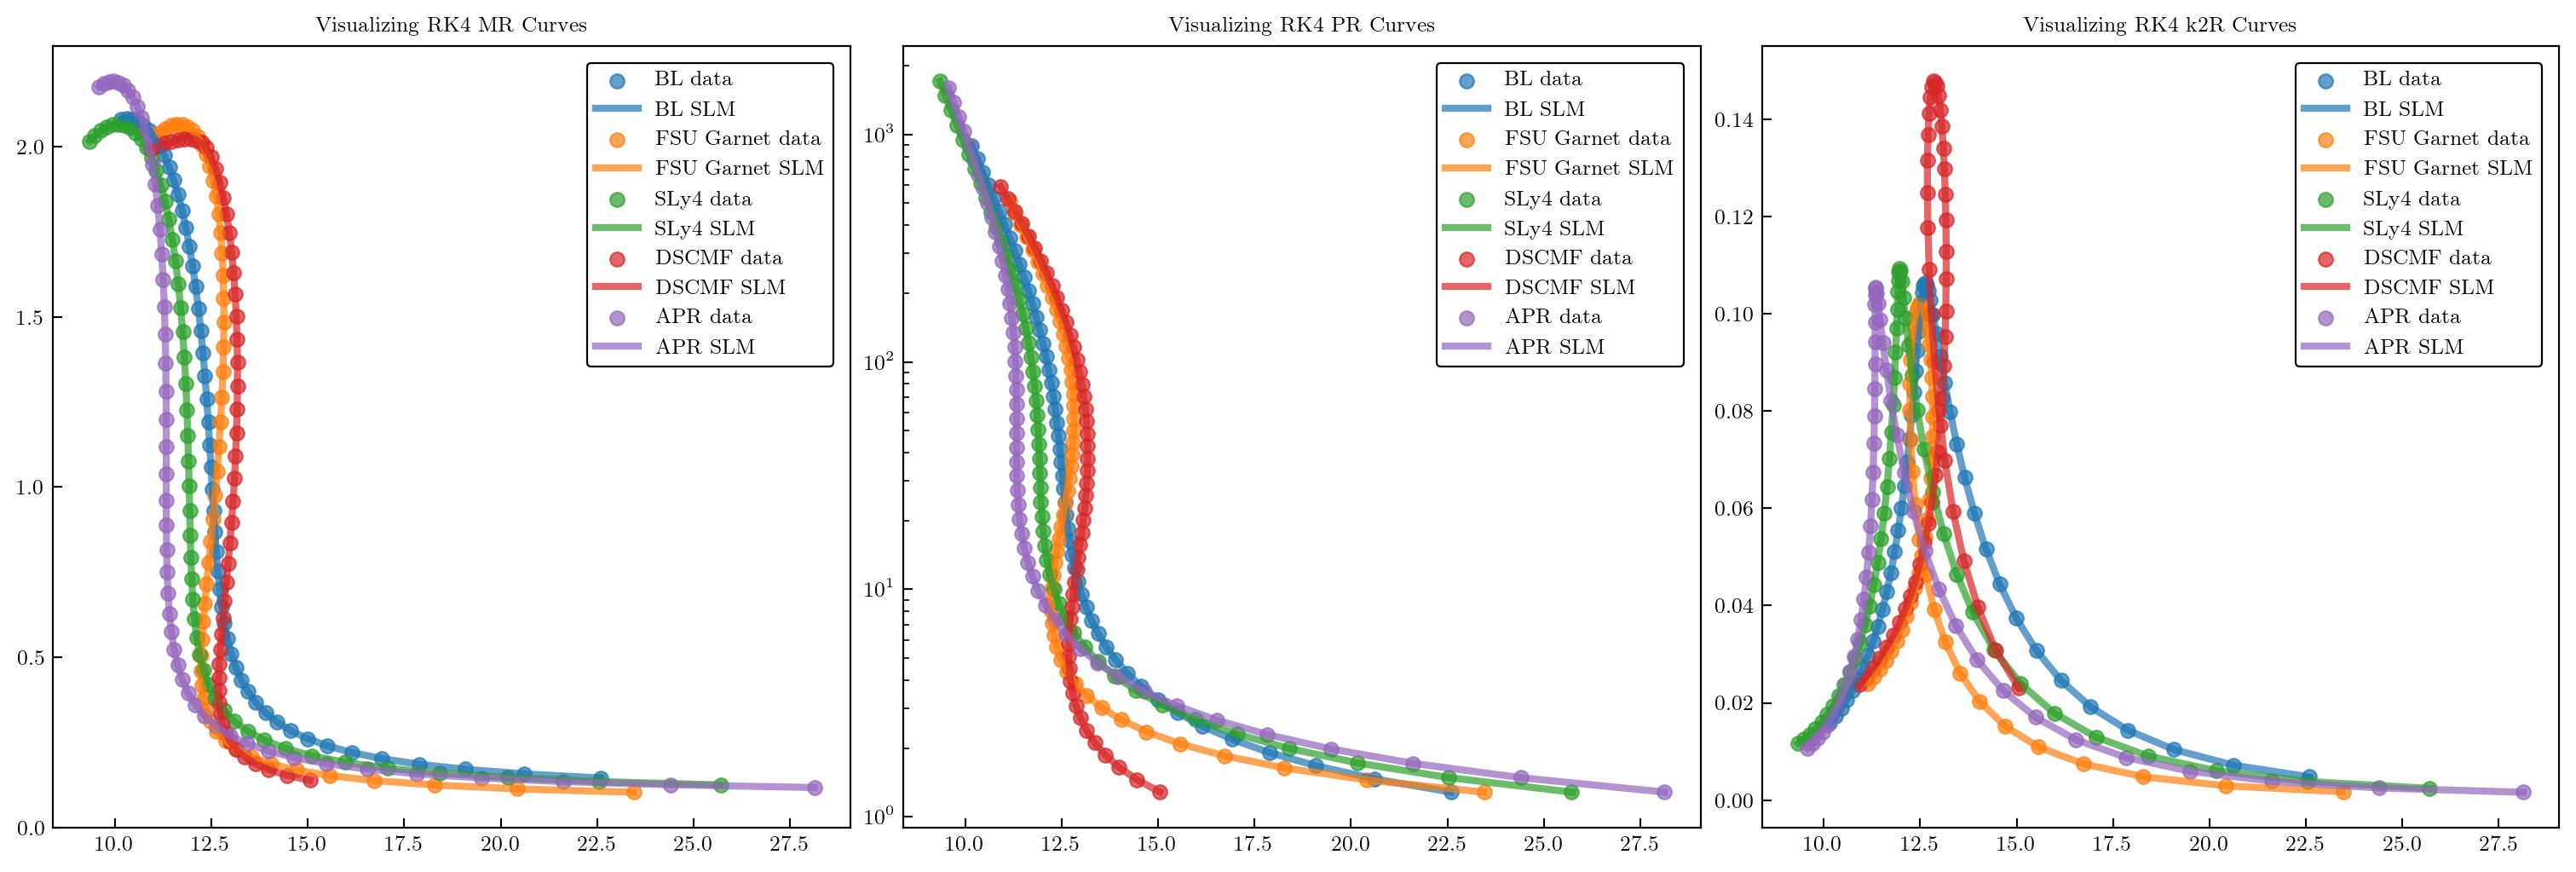

In [10]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing RK4 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing RK4 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].set_yscale("log")
ax[1].legend()

ax[2].set_title("Visualizing RK4 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Check RK2 Solver

In [11]:
# store the solutions per EOS
RK2_HF_results = {}
RK2_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK2 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK2", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK2.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK2"].append(HF_runtime)
        
        # store data
        rad = tov_RK2.total_radius
        pres = tov_RK2.total_pres_central
        mass = tov_RK2.total_mass
        tidal = tov_RK2.k2

        X = np.asarray([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        # X_SLM = SLM(X, dt, error_threshold=error_threshold)[4]
        SLM_result = SLM(X, dt, error_threshold=error_threshold, modes=modes)
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        SLM_runtimes["RK2"].append(SLM_runtime)

        RK2_HF_results[eos_name] = np.exp(X)
        RK2_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime:.2}")
#




Checking BL: Woo it worked!
Max mass:  2.083269 Radius:  10.327494 Central pressure:  782.931436
Testing r=1: Max absolute error = 6.892106
Testing r=2: Max absolute error = 1.979835
Testing r=3: Max absolute error = 0.643073
Testing r=4: Max absolute error = 0.290968
Testing r=5: Max absolute error = 0.041028
Testing r=6: Max absolute error = 0.029007
Testing r=7: Max absolute error = 0.009082
Testing r=8: Max absolute error = 0.027219
Testing r=9: Max absolute error = 0.002918
Testing r=10: Max absolute error = 0.003819
Testing r=11: Max absolute error = 0.002652
Testing r=12: Max absolute error = 0.002545
Testing r=13: Max absolute error = 0.002668
Testing r=14: Max absolute error = 0.002542
Optimal 'r' determined: 14 (Max absolute error = 0.002542)
HF solved in 9.296 seconds.
SLM solved in 0.00195 seconds.
speedup: 4.8e+03


Checking FSU Garnet: Woo it worked!
Max mass:  2.066414 Radius:  11.609007 Central pressure:  352.826244
Testing r=1: Max absolute error = 5.693746
Testing r

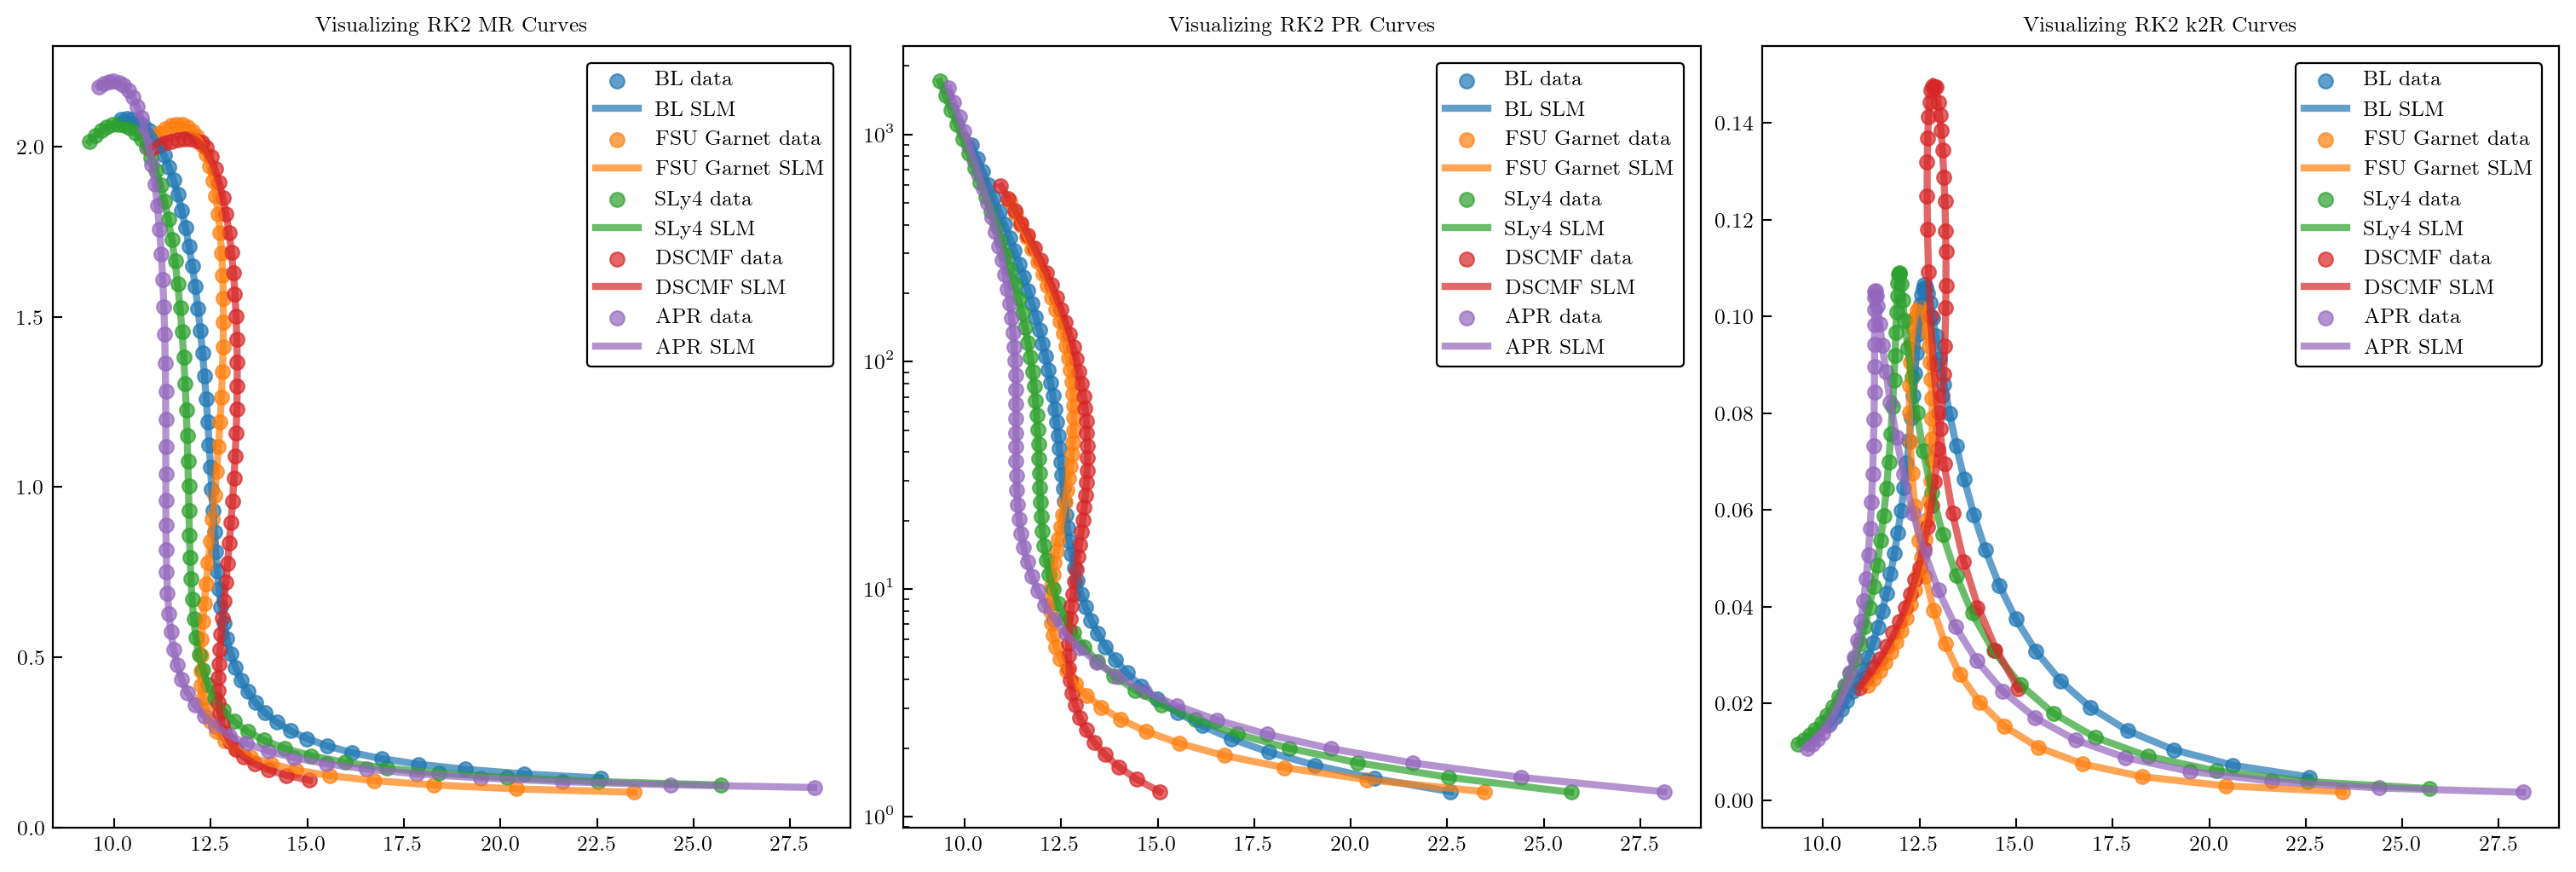

In [12]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing RK2 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing RK2 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].set_yscale("log")
ax[1].legend()

ax[2].set_title("Visualizing RK2 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

# Check Euler Solver

In [13]:
# store the solutions per EOS
euler_HF_results = {}
euler_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_euler = TOVsolver(f"{eos_path}{file}", tidal=True, solver="euler", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_euler.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["euler"].append(HF_runtime)
        
        # store data
        rad = tov_euler.total_radius
        pres = tov_euler.total_pres_central
        mass = tov_euler.total_mass
        tidal = tov_euler.k2

        X = np.asarray([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        # X_SLM = SLM(X, dt, error_threshold=error_threshold)[4]
        SLM_result = SLM(X, dt, error_threshold=error_threshold, modes=modes)
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["euler"].append(SLM_runtime)
        
        euler_HF_results[eos_name] = np.exp(X)
        euler_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime:.2}")
#




Checking BL: Woo it worked!
Max mass:  2.082633 Radius:  10.235359 Central pressure:  782.931436
Testing r=1: Max absolute error = 6.811833
Testing r=2: Max absolute error = 1.976708
Testing r=3: Max absolute error = 0.643862
Testing r=4: Max absolute error = 0.289479
Testing r=5: Max absolute error = 0.041469
Testing r=6: Max absolute error = 0.028246
Testing r=7: Max absolute error = 0.008385
Testing r=8: Max absolute error = 0.006948
Testing r=9: Max absolute error = 0.005237
Testing r=10: Max absolute error = 0.002819
Testing r=11: Max absolute error = 0.002762
Testing r=12: Max absolute error = 0.002918
Testing r=13: Max absolute error = 0.002725
Testing r=14: Max absolute error = 0.003998
Optimal 'r' determined: 13 (Max absolute error = 0.002725)
HF solved in 4.481 seconds.
SLM solved in 0.001866 seconds.
speedup: 2.4e+03


Checking FSU Garnet: Woo it worked!
Max mass:  2.066085 Radius:  11.533624 Central pressure:  352.826244
Testing r=1: Max absolute error = 5.713431
Testing 

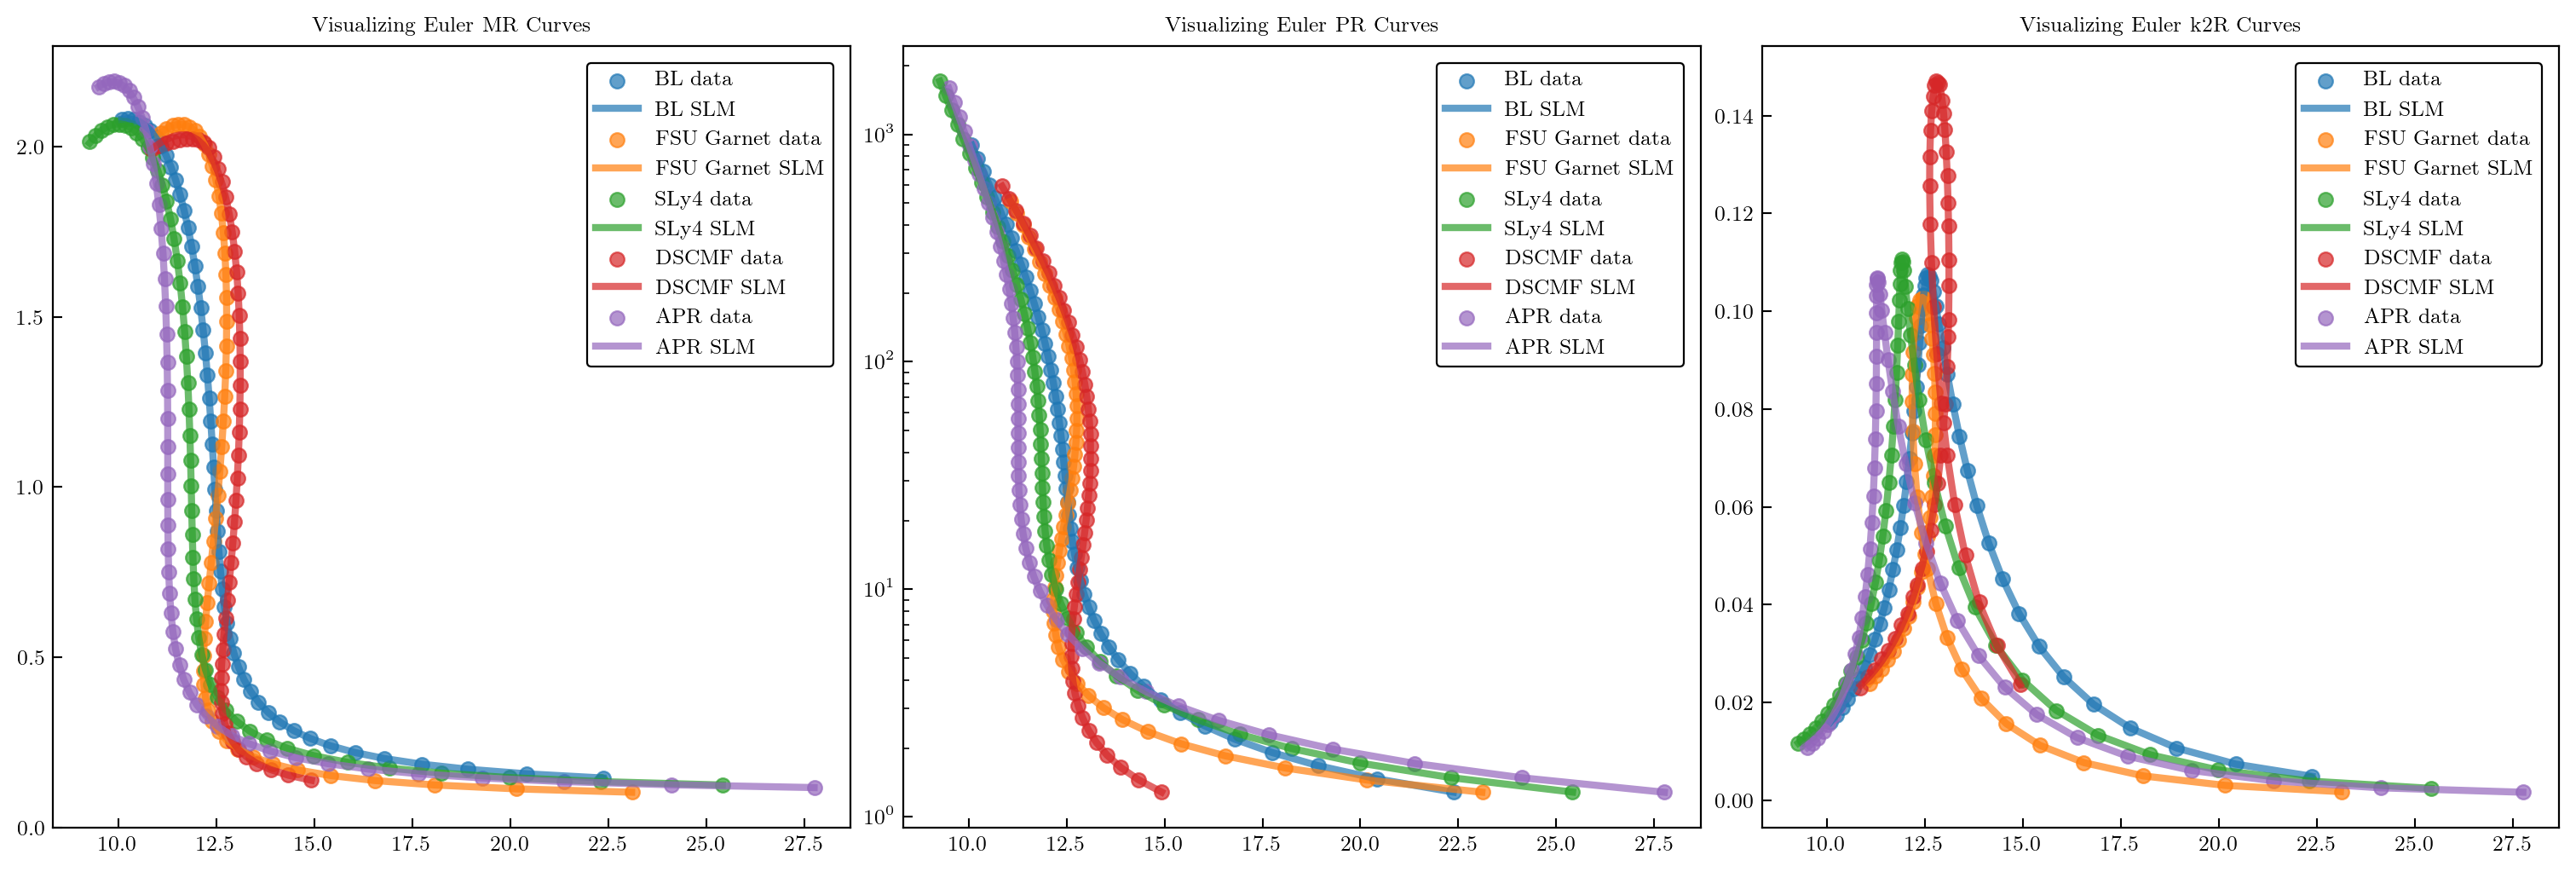

In [14]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing Euler MR Curves")
for eos in eos_names:
    ax[0].scatter(euler_HF_results[eos][0], euler_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing Euler PR Curves")
for eos in eos_names:
    ax[1].scatter(euler_HF_results[eos][0], euler_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].set_yscale("log")
ax[1].legend()

ax[2].set_title("Visualizing Euler k2R Curves")
for eos in eos_names:
    ax[2].scatter(euler_HF_results[eos][0], euler_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Nice! Now look at errors

I'm not totally sure the best way to go about this. So I'll look at where the peak is on the MR curve since that's how we did the errors on the table originally.

In [15]:
def the_good_interpolator(x_tov, y_tov, x_dmd):
    # Create a normalized parameter t that corresponds to the original x values
    t_original = np.linspace(0, 1, num=len(x_tov))
    
    # Create cubic splines for original x and y
    cs_x = CubicSpline(t_original, x_tov, bc_type='natural')
    cs_y = CubicSpline(t_original, y_tov, bc_type='natural')
    
    # Create a new parameter t for the new x-values
    t_new = np.linspace(0, 1, num=len(x_dmd))
    
    # Interpolate to find the corresponding y-values for the new x-values
    y_new = cs_y(t_new)
    
    return x_dmd, y_new

def percent_error(HF, SLM):
    try:
        error = 100 * np.abs(HF - SLM) / HF
    except:
        error = np.nan
    return error

In [16]:
errors = {}  # for storing all errors
exact_HF = []  # for comparing HF solvers to the exact results

solvers = ["exact", "RK4", "RK2", "euler"]
for solver in solvers:
    for i, eos in enumerate(files_to_check):
        eos_name = eos_names[i]
        HF = eval(f"{solver}_HF_results[\"{eos_name}\"]")
        SLM_data = eval(f"{solver}_SLM_results[\"{eos_name}\"]")
        
        # select max point on MR curve
        # for HF
        HF_max_index = np.where(HF[2] == np.max(HF[2]))[0][0]  # grab index the maximum mass
        HF_max_rad = HF[0][HF_max_index]
        HF_max_mass = HF[2][HF_max_index]
        # for SLM
        SLM_max_index = np.where(SLM_data[2] == np.max(SLM_data[2]))[0][0]  # grab index the maximum mass
        SLM_max_rad = SLM_data[0][SLM_max_index]
        SLM_max_mass = SLM_data[2][SLM_max_index]
        
        # store the exact results for comparing to the other solvers
        if (solver == "exact"):
            exact_HF.append([HF_max_rad, HF_max_mass])
        else:
            errors[f"{eos_name} {solver} HF rad"] = percent_error(exact_HF[i][0], HF_max_rad)
            errors[f"{eos_name} {solver} HF mass"] = percent_error(exact_HF[i][1], HF_max_mass)
        
        # compare SLM to it's corresponding HF solver
        errors[f"{eos_name} {solver} SLM rad"] = percent_error(HF_max_rad, SLM_max_rad)
        errors[f"{eos_name} {solver} SLM mass"] = percent_error(HF_max_mass, SLM_max_mass)


# print results
for i, eos in enumerate(files_to_check):
    eos_name = eos_names[i]
    print(f"{eos_name} EOS:")
    for solver in solvers:
        if (solver != "exact"):
            print(f"{solver} HF  error:")
            print(f"   rad={errors[f"{eos_name} {solver} HF rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} HF mass"]:.6}")
            print(f"{solver} SLM error:")
            print(f"   rad={errors[f"{eos_name} {solver} SLM rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} SLM mass"]:.6}")
        else:
            print(f"{solver} SLM error:")
            print(f"   rad={errors[f"{eos_name} {solver} SLM rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} SLM mass"]:.6}")
    print("")


BL EOS:
exact SLM error:
   rad=0.0227623
   mass=0.00447911
RK4 HF  error:
   rad=0.0072636
   mass=2.30522e-06
RK4 SLM error:
   rad=0.0319399
   mass=0.00240452
RK2 HF  error:
   rad=0.155194
   mass=0.000194292
RK2 SLM error:
   rad=0.0270922
   mass=0.000654774
euler HF  error:
   rad=0.738323
   mass=0.0303505
euler SLM error:
   rad=0.000109445
   mass=0.00298102

FSU Garnet EOS:
exact SLM error:
   rad=0.0026224
   mass=5.42693e-05
RK4 HF  error:
   rad=0.0332715
   mass=6.87809e-07
RK4 SLM error:
   rad=0.0204106
   mass=0.0197291
RK2 HF  error:
   rad=0.0389066
   mass=0.000129845
RK2 SLM error:
   rad=0.0178839
   mass=0.000937513
euler HF  error:
   rad=0.610697
   mass=0.0157712
euler SLM error:
   rad=0.0144315
   mass=0.00779571

SLy4 EOS:
exact SLM error:
   rad=0.0502768
   mass=0.0252109
RK4 HF  error:
   rad=0.0166824
   mass=3.54751e-06
RK4 SLM error:
   rad=0.0202399
   mass=0.010647
RK2 HF  error:
   rad=0.149265
   mass=0.000182519
RK2 SLM error:
   rad=0.0506061

## Cat Plot !


```
 _._     _,-'""`-._        
(,-.`._,'(       |\`-/|    
    `-.-' \ )-`( , o o)    
          `-    \`_`"'-    
```

BL
FSU Garnet
SLy4
DSCMF
APR


/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_72817/1629970737.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


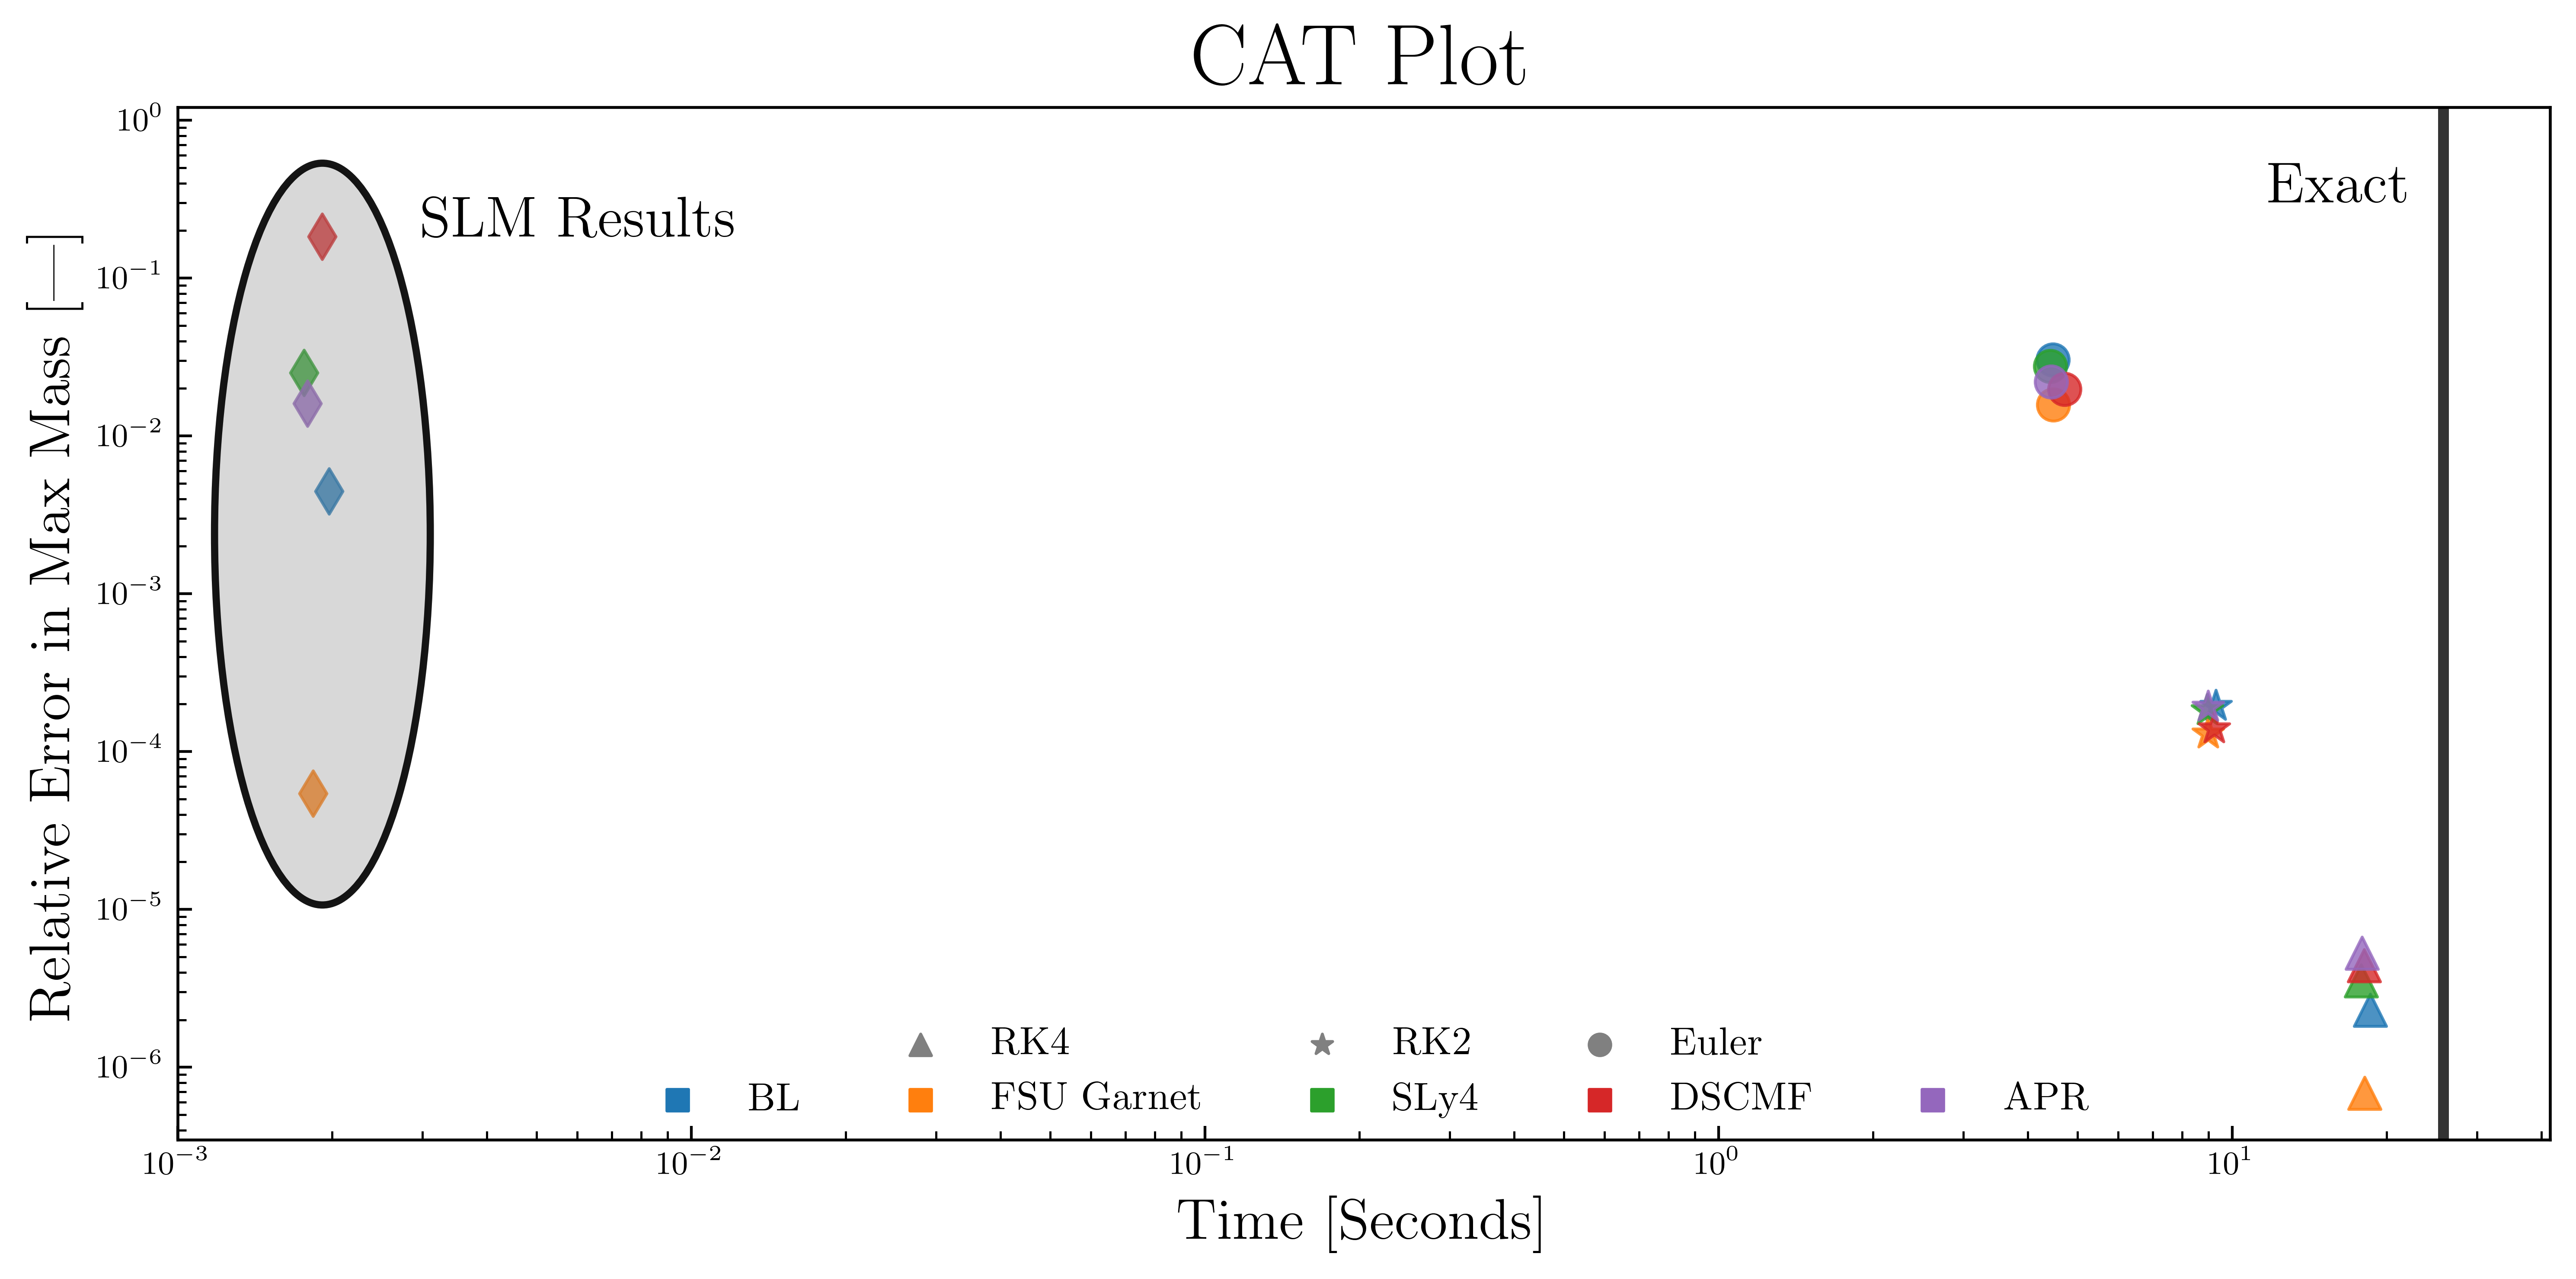

In [32]:
from matplotlib.patches import Ellipse
from matplotlib.transforms import ScaledTranslation


colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
markers = ["d", "^", "*", "o"]
sizes = [80] * 2  # [75, 25]

alpha = 0.8

SLM_timings = []
SLM_accuracy = []


fig, ax = plt.subplots(1, 1, dpi=600, figsize=(10, 5))
ax.set_title("CAT Plot", fontsize=24)

for i, eos in enumerate(files_to_check):
    eos_name = eos_names[i]
    for j, solver in enumerate(solvers):
        SLM_error = errors[f"{eos_name} {solver} SLM mass"]
        
        SLM_timings.append(SLM_runtimes[solver][i])
        SLM_accuracy.append(errors[f"{eos_name} {solver} SLM mass"])
        
        if (solver != "exact"):
            HF_error = errors[f"{eos_name} {solver} HF mass"]
            
            ax.scatter(HF_runtimes[solver][i], 
                       HF_error, 
                       marker=markers[j],
                       color=colors[i],
                       s=sizes[0], 
                       alpha=alpha,
                       # label=f"{eos_name} {solver.capitalize() if solver == "euler" else solver.upper()}"
                       )
            # ax.scatter(SLM_runtimes[solver][i], 
            #            SLM_error, 
            #            marker=markers[j],
            #            color=colors[i], 
            #            s=sizes[1],
            #            alpha=alpha)#, label=f"{eos_name} SLM")
        else:
            ax.scatter(SLM_runtimes[solver][i], 
                       SLM_error, 
                       marker=markers[j],
                       color=colors[i], 
                       s=sizes[1],
                       alpha=alpha, 
                       # label=f"{eos_name} SLM"
                       )
        
        if i == 0:
            if solver != "exact":
                ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="grey", marker=markers[j], label=f"{solver.capitalize() if solver == "euler" else solver.upper()}")
            else:
                ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="white", marker=markers[j], label=f" ")
    print(eos_name)
    ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[i], marker="s", label=f"{eos_name}")
# ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[0], marker="s", label=f"Exact")
#

ax.annotate("Exact", (np.mean(HF_runtimes["exact"]) - 14, 3.0 * 1e-1), fontsize=16)
ax.axvline(np.mean(HF_runtimes["exact"]),
           alpha=alpha, color="black", linewidth=3)#, label=f"{eos_name} {solver.capitalize()}")



ax.annotate("SLM Results", (3.0 * 1e-3, 1.8 * 1e-1), fontsize=16)
# Ellipse centre coordinates
x, y = (np.mean(SLM_timings), np.mean(SLM_accuracy))
# x -= 0 * 1e-4
y -= 0.083
# use the axis scale tform to figure out how far to translate 
ell_offset = ScaledTranslation(x, y, ax.transScale)
# construct the composite tform
ell_tform = ell_offset + ax.transLimits + ax.transAxes
ellipse_1 = Ellipse((x, y), 0.42, 4.7,  color="grey", fill=True, alpha=0.3, linewidth=2, transform=ell_tform)
ellipse_2 = Ellipse((x, y), 0.42, 4.7,  color="black", fill=False, alpha=0.9, linewidth=2, transform=ell_tform)
ax.add_patch(ellipse_1)
ax.add_patch(ellipse_2)



ax.set_xlabel("Time [Seconds]",               fontsize=16)
ax.set_ylabel("Relative Error in Max Mass [---]", fontsize=16)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])

handles, labels = plt.gca().get_legend_handles_labels()
# order = [4, 5, 6, 7, 8, 0, 1, 2, 3]  # label EOSs first, then solvers
# order = [4, 0, 5, 1, 6, 2, 7, 3, 8]
order = [0, 4, 1, 5, 2, 6, 3, 7, 0, 8]
ax.legend([handles[i] for i in order], [labels[i] for i in order], 
          loc="lower center", ncols=5, framealpha=0., fontsize=11, bbox_to_anchor=(0.5, -0.025))
plt.tight_layout()
plt.savefig("./../Plots/CAT-rad.pdf")
plt.show()


BL
FSU Garnet
SLy4
DSCMF
APR


/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_72817/243748495.py:98: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


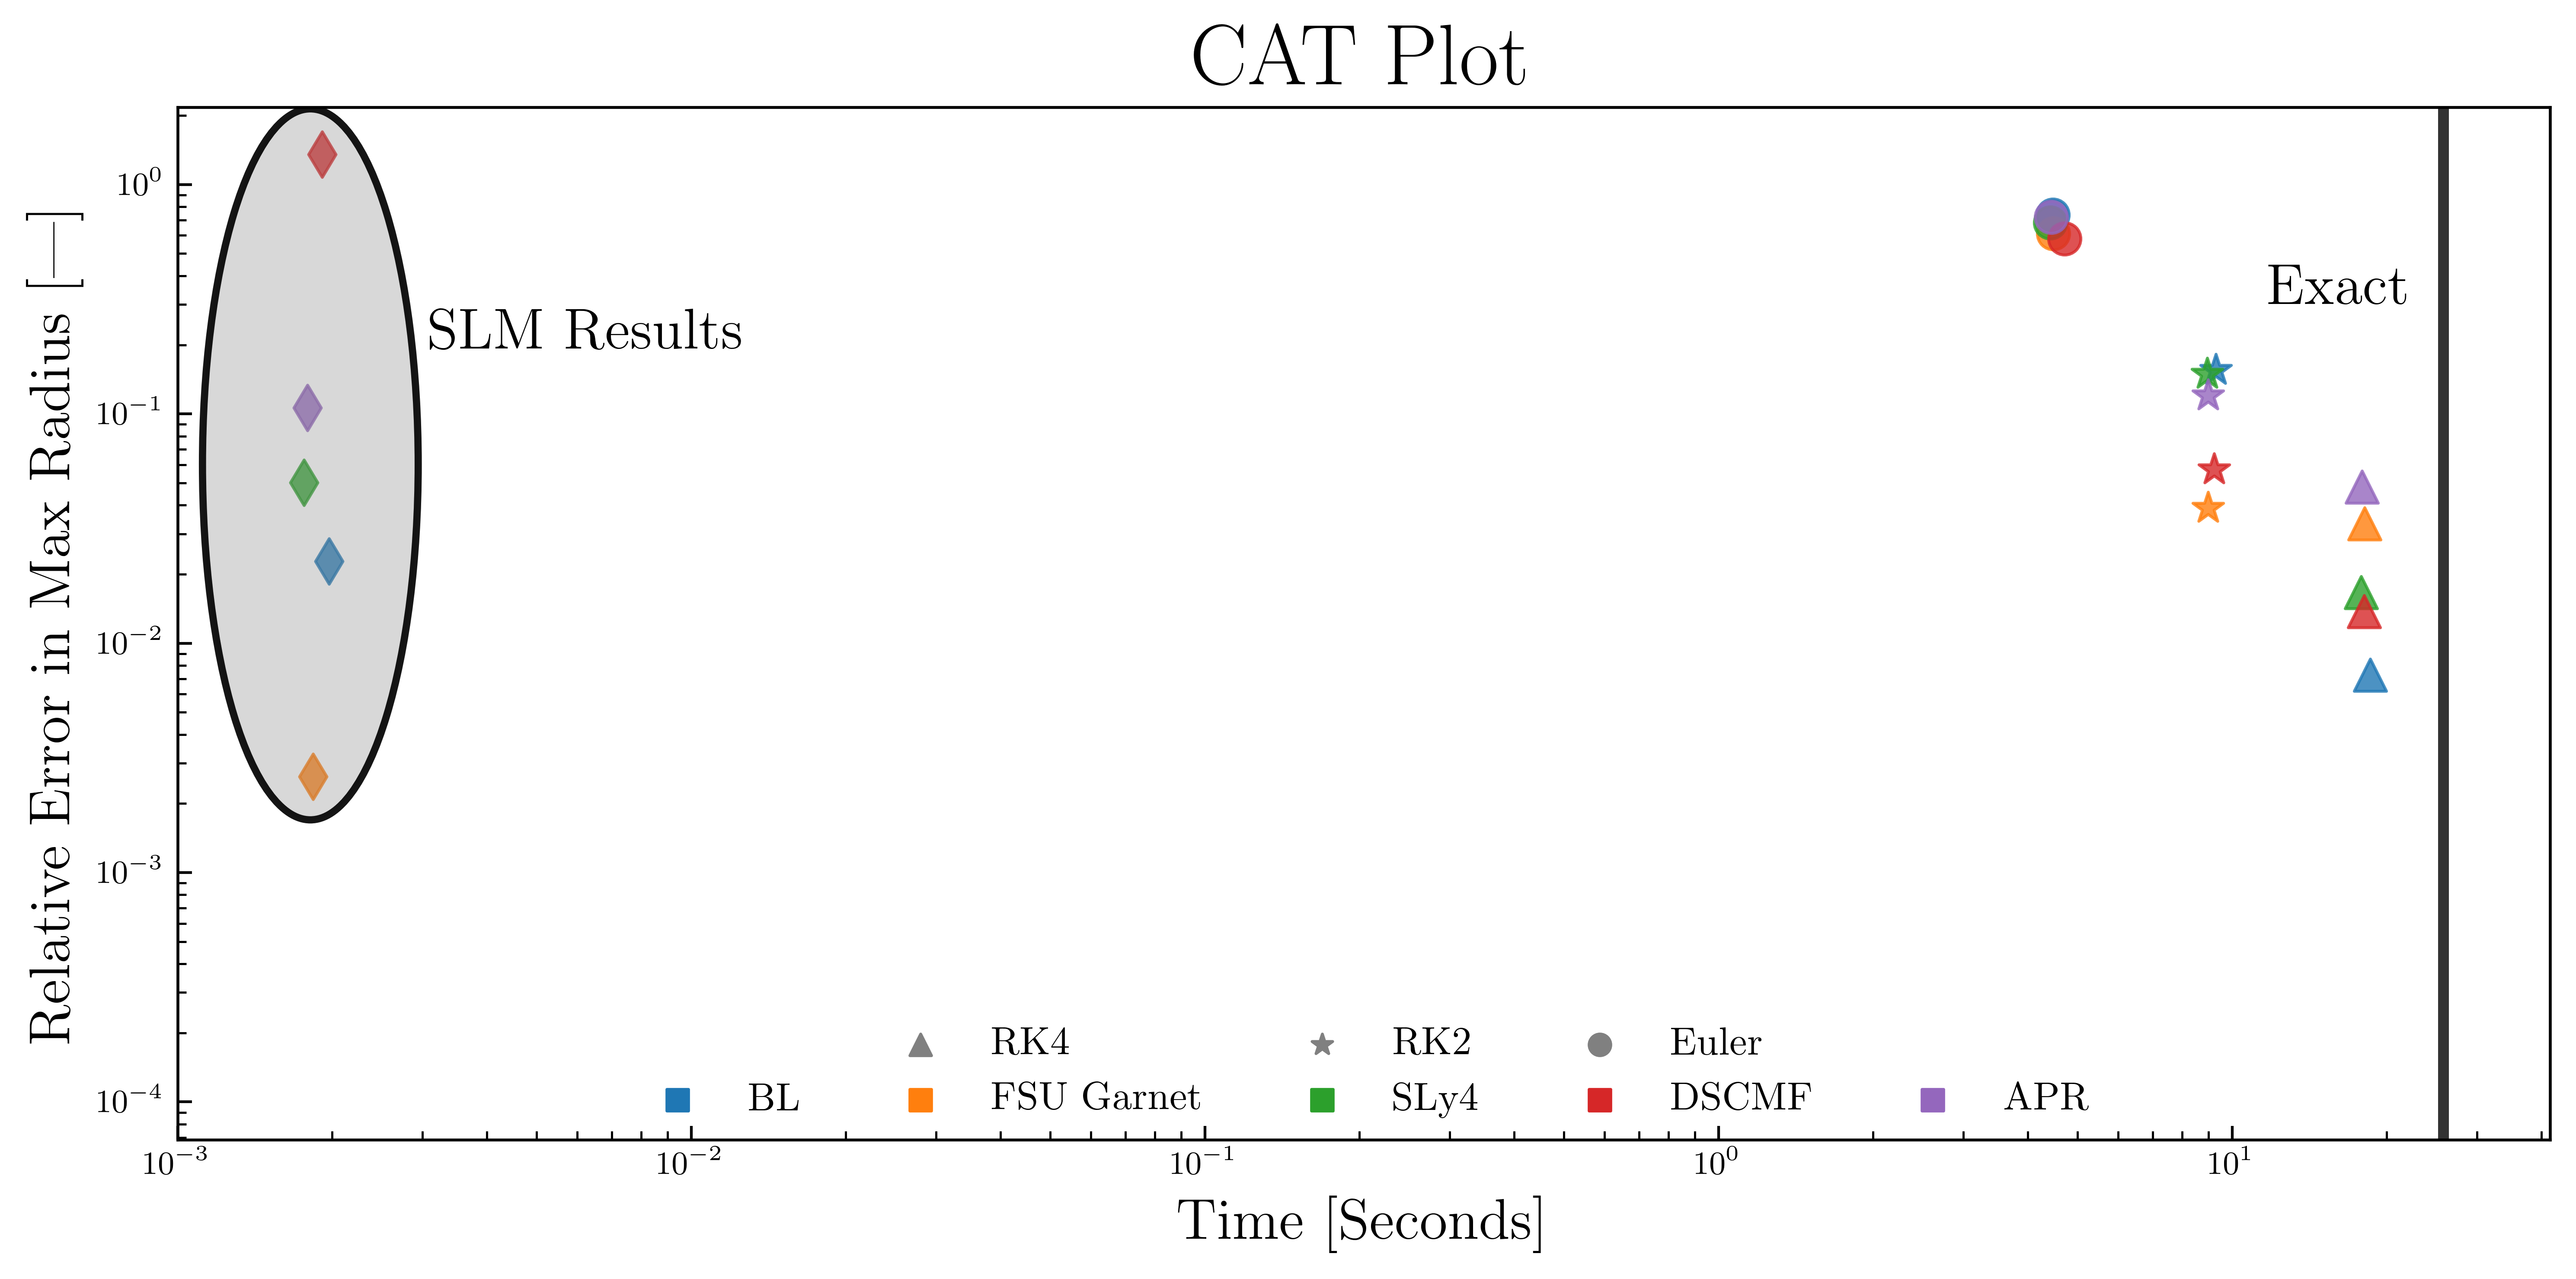

In [53]:
from matplotlib.patches import Ellipse
from matplotlib.transforms import ScaledTranslation


colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
markers = ["d", "^", "*", "o"]
sizes = [80] * 2  # [75, 25]

alpha = 0.8

SLM_timings = []
SLM_accuracy = []


fig, ax = plt.subplots(1, 1, dpi=600, figsize=(10, 5))
ax.set_title("CAT Plot", fontsize=24)

for i, eos in enumerate(files_to_check):
    eos_name = eos_names[i]
    for j, solver in enumerate(solvers):
        SLM_error = errors[f"{eos_name} {solver} SLM rad"]
        
        SLM_timings.append(SLM_runtimes[solver][i])
        SLM_accuracy.append(errors[f"{eos_name} {solver} SLM rad"])
        
        if (solver != "exact"):
            HF_error = errors[f"{eos_name} {solver} HF rad"]
            
            ax.scatter(HF_runtimes[solver][i], 
                       HF_error, 
                       marker=markers[j],
                       color=colors[i],
                       s=sizes[0], 
                       alpha=alpha,
                       # label=f"{eos_name} {solver.capitalize() if solver == "euler" else solver.upper()}"
                       )
            # ax.scatter(SLM_runtimes[solver][i], 
            #            SLM_error, 
            #            marker=markers[j],
            #            color=colors[i], 
            #            s=sizes[1],
            #            alpha=alpha)#, label=f"{eos_name} SLM")
        else:
            ax.scatter(SLM_runtimes[solver][i], 
                       SLM_error, 
                       marker=markers[j],
                       color=colors[i], 
                       s=sizes[1],
                       alpha=alpha, 
                       # label=f"{eos_name} SLM"
                       )
        
        if i == 0:
            if solver != "exact":
                ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="grey", marker=markers[j], label=f"{solver.capitalize() if solver == "euler" else solver.upper()}")
            else:
                ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="white", marker=markers[j], label=f" ")
    print(eos_name)
    ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[i], marker="s", label=f"{eos_name}")
# ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[0], marker="s", label=f"Exact")
#

ax.annotate("Exact", (np.mean(HF_runtimes["exact"]) - 14, 3.0 * 1e-1), fontsize=16)
ax.axvline(np.mean(HF_runtimes["exact"]),
           alpha=alpha, color="black", linewidth=3)#, label=f"{eos_name} {solver.capitalize()}")



ax.annotate("SLM Results", (3.1 * 1e-3, 1.9 * 1e-1), fontsize=16)
# Ellipse centre coordinates
x, y = (np.mean(SLM_timings), np.mean(SLM_accuracy))
x -= 1 * 1e-4
y -= 0.048
# use the axis scale tform to figure out how far to translate 
ell_offset = ScaledTranslation(x, y, ax.transScale)
# construct the composite tform
ell_tform = ell_offset + ax.transLimits + ax.transAxes
ellipse_1 = Ellipse((x, y), 0.42, 3.1,  color="grey", fill=True, alpha=0.3, linewidth=2, transform=ell_tform)
ellipse_2 = Ellipse((x, y), 0.42, 3.1,  color="black", fill=False, alpha=0.9, linewidth=2, transform=ell_tform)
ax.add_patch(ellipse_1)
ax.add_patch(ellipse_2)



ax.set_xlabel("Time [Seconds]",                     fontsize=16)
ax.set_ylabel("Relative Error in Max Radius [---]", fontsize=16)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])

handles, labels = plt.gca().get_legend_handles_labels()
# order = [4, 5, 6, 7, 8, 0, 1, 2, 3]  # label EOSs first, then solvers
# order = [4, 0, 5, 1, 6, 2, 7, 3, 8]
order = [0, 4, 1, 5, 2, 6, 3, 7, 0, 8]
ax.legend([handles[i] for i in order], [labels[i] for i in order], 
          loc="lower center", ncols=5, framealpha=0., fontsize=11, bbox_to_anchor=(0.5, -0.025))

plt.tight_layout()
plt.savefig("./../Plots/CAT-mass.pdf")
plt.show()


In [19]:
np.mean(list(HF_runtimes.values())) / np.mean(list(SLM_runtimes.values()))

np.float64(7533.709495669575)